# Probabilistic SLAM in Gen - Tutorial - Part 2 <br/> Straight forward solutions

In [1]:
# This is a fix for vscode, because it doesn't like 
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
include("src/slam_tutorial_part_1.jl");

Loading `../data/mit-csail.json` ...

	_zs        Vector{Vector{Float64}}
	_zs_inf    Vector{Vector{Float64}}
	_as        Vector{Float64}
	_zmax      Float64
	_ys        Vector{Vector{Vector{Float64}}}
	_ys_inf    Vector{Vector{Vector{Float64}}}
	_num_a     Int64
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64


## First SLAM model

In [3]:
#nbx --fname=src/slam_tutorial_part_2.jl
by_not_infs(x) = all(x.!=Inf) && all(x.!=-Inf)

by_not_infs (generic function with 1 method)

In [4]:
#nbx
@gen function first_slam_model(T, t0, step, ys, us, x_noise, hd_noise, w, s_noise, outlier, outliver_vol, zmax)
    
    ps = [Pose()]
    xs = []
    zs = []

    ms = [ys[t0]]

    for i = 1:T
        t1 = t0 + (i-1) * step
        t2 = t0 +     i * step

        p = ps[i]
        m = ms[i]
        ũ = sum(us[t1:t2-1])
        u = Control(rot(-_hds[t1]+p.hd)*ũ.dx, ũ.dhd)

        p′    = {i => :pose}   ~ motion_model(p, u, x_noise, hd_noise)
        x′,z′ = {i => :sensor} ~ sensor_model(p′, m, w, s_noise, outlier, outliver_vol, zmax)    
        
        # Need to filter Inf's otherwise 
        # creates NaN's when pose gets applied.
        x′ = filter(by_not_infs, x′)
        

        push!(ps,p′)
        push!(xs,x′)
        push!(zs,z′)
        push!(ms, vcat(m, x′.*p′) )

    end
    
    return Dict(:ps=>ps,:xs=>xs,:ms=>ms, :zs=>zs)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##first_slam_model#349", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], false)

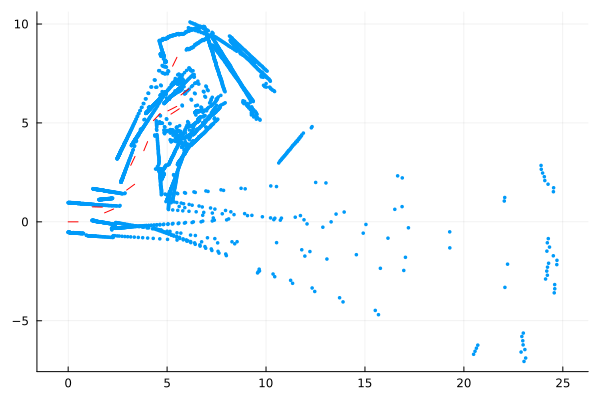

In [15]:
x_noise  = 0.4
hd_noise = 10/360*2π

w           = 10
s_noise     = 0.2
outlier     = 1e-3
outlier_vol = 1.0
zmax = Inf

t0   = 1050
step = 4
T    = 10

ys = _ys_inf
us = _us

ch = choicemap()
for i=1:T
    ch[i => :sensor => :x] = _ys_inf[t0 + i*step]
end

args = (T, t0, step, ys, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol, zmax)
tr,w = generate(first_slam_model, args, ch)
ps = tr[][:ps]
ms = tr[][:ms]



# ------------------
mypl = plot(legend=nothing, aspect_ratio=:equal)
scatter!(ms[end], markersize=2, markerstrokewidth=0, c=col[1])
plot!(ps, markersize=6, c=:red)
mypl

In [16]:
#nbx
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
argdiffs([0,0.0,1.0, 1])

(NoChange(), NoChange(), UnknownChange(), UnknownChange())

true, 1
true, 1 (362.16 ms)
true, 1 (393.01 ms)
true, 1 (700.95 ms)
true, 1 (657.12 ms)
true, 2 (956.32 ms)
true, 1 (1077.16 ms)
true, 3 (1228.47 ms)
true, 1 (1371.34 ms)
true, 1 (1547.48 ms)


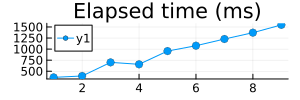

In [17]:
N = 100

# Initialize the PF
ch = choicemap()
ch[1 => :sensor => :x] = _ys_inf[t0 + step]
state = initialize_particle_filter(first_slam_model, (1, args[2:end]...), ch, N);

# (Approximately) "ensure"  that the 
# initial particles are samples from the posterior
r = maybe_resample!(state)

# Look at the initial state
println("$(r), $(length(Set(state.parents)))")

diffs = argdiffs([1; zeros(length(args)-1)])
times_vanilla = []
for i=2:T

    # Set incoming observations
    ch = choicemap()
    ch[i => :sensor => :x] = _ys_inf[t0 + i*step]

    # Step forward and maybe resample
    sec = @elapsed dw, = particle_filter_step!(state, (i, args[2:end]...), diffs, ch)
    r = maybe_resample!(state; ess_threshold=N/3)

    # Collect runtimes and plot stuff
    ms = sec*1_000
    push!(times_vanilla, ms)
    println("$(r), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

# ----------------------
plot(times_vanilla, size=(300,100), title="Elapsed time (ms)", marker=:o)

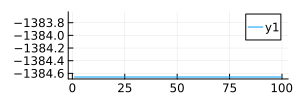

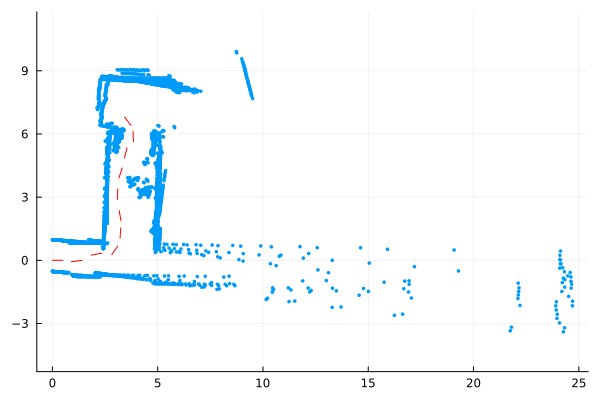

In [8]:
trs = state.traces
scores = get_score.(trs)

perm   = sortperm(scores)
trs    = trs[perm]
scores = scores[perm]

tr = trs[end]

ps = tr[][:ps]
ms = tr[][:ms]
# ------------------
display(plot(scores, size=(300,100)))
# ---
mypl = plot(legend=nothing, aspect_ratio=:equal)
scatter!(ms[end], markersize=2, markerstrokewidth=0, c=col[1])
plot!(ps, markersize=6, c=:red)
mypl

## Unfolded SLAM Kernel

In [9]:
#nbx
@gen function slam_kernel(i, state, t0, step, us, x_noise, hd_noise, w, s_noise, outlier, outliver_vol, zmax)

    # The map could be sample and set during updates
    p,_,m = state

    t1 = t0 + (i-1) * step
    t2 = t0 +     i * step
    ũ = sum(us[t1:t2-1])
    u = Control(rot(-_hds[t1]+p.hd)*ũ.dx, ũ.dhd)

    p′    = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
    x′,z′ = {:sensor} ~ sensor_model(p′, m, w, s_noise, outlier, outliver_vol, zmax)    
    
    # Need to filter Inf's otherwise 
    # creates NaN's when pose gets applied.
    x′ = filter(by_not_infs, x′)
    
    # Add the current observation to the map
    m′ = vcat(m, x′.*p′)

    state = (p′, x′, m′)
    return state
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [10]:
#nbx
get_last_pose(tr) = tr[][end][1]
get_last_map(tr)  = tr[][end][3]

get_last_map (generic function with 1 method)

In [11]:
x_noise  = 0.1
hd_noise = 5/360*2π

w           = 10
s_noise     = 0.2
outlier     = 1e-3
outlier_vol = 1.0
zmax = Inf

t0   = 1050
step = 4
T    = 10

ys = _ys_inf
us = _us


ch = choicemap()
for i=1:T
    ch[i => :sensor => :x] = _ys_inf[t0 + i*step]
end

args = (T, (Pose(), nothing, ys[t0]), t0, step, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol, zmax)
tr,w = generate(slam_chain, args, ch)

(Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}(Unfold{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##slam_kernel#837", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], false)), Gen.DynamicDSLTrace[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##slam_kernel#837", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:pose => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(

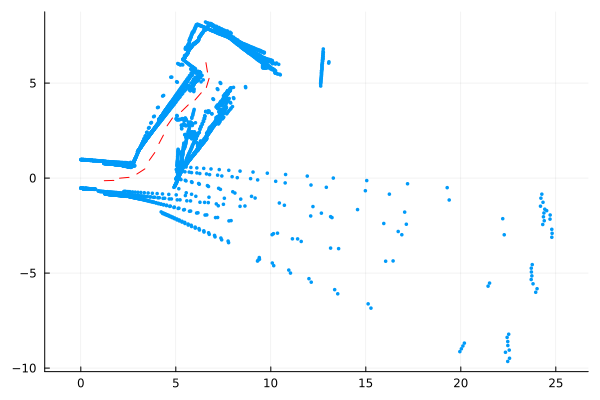

In [12]:
ps = [re[1] for re in tr[]]
ms = [re[3] for re in tr[]]

# ------------------
mypl = plot(legend=nothing, aspect_ratio=:equal)
scatter!(ms[end], markersize=2, markerstrokewidth=0, c=col[1])
plot!(ps, markersize=6, c=:red)
mypl

### Particle Filter

true, 1
true, 1 (131.09 ms)
true, 1 (136.35 ms)
true, 2 (134.19 ms)
true, 1 (134.98 ms)
true, 1 (135.43 ms)
true, 1 (139.51 ms)
true, 1 (312.03 ms)
true, 1 (138.98 ms)
true, 1 (141.15 ms)


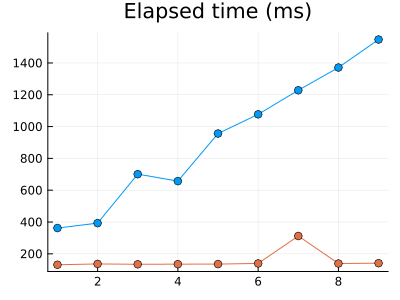

In [19]:
N = 100

x_noise  = 0.4
hd_noise = 10/360*2π

w           = 10
s_noise     = 0.2
outlier     = 1e-3
outlier_vol = 1.0
zmax = Inf

t0   = 1050
step = 4
T    = 10

ys = _ys_inf
us = _us

# Initialize the PF
ch = choicemap()
ch[1 => :sensor => :x] = _ys_inf[t0 + step]

args = (T, (Pose(), nothing, ys[t0]), t0, step, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol, zmax)
state = initialize_particle_filter(slam_chain, (1, args[2:end]...), ch, N);

# (Approximately) "ensure"  that the 
# initial particles are samples from the posterior
r = maybe_resample!(state)

# Look at the initial state
println("$(r), $(length(Set(state.parents)))")

diffs = argdiffs([1; zeros(length(args)-1)])
times = []
for i=2:T

    # Set incoming observations
    ch = choicemap()
    ch[i => :sensor => :x] = _ys_inf[t0 + i*step]

    # Step forward and maybe resample
    sec = @elapsed dw, = particle_filter_step!(state, (i, args[2:end]...), diffs, ch)
    r = maybe_resample!(state; ess_threshold=N/4)

    # Collect runtimes and plot stuff
    ms = sec*1_000
    push!(times, ms)
    println("$(r), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end


# ----------------------
plot(size=(400,300), title="Elapsed time (ms)", legend=nothing)
plot!(times_vanilla, marker=:o)
plot!(times, marker=:o)

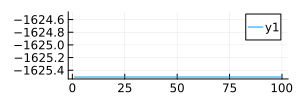

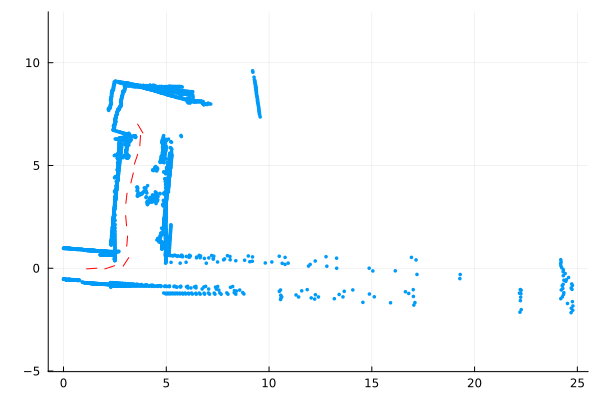

In [141]:
trs    = state.traces
scores = get_score.(trs)
perm   = sortperm(scores)
trs    = trs[perm]
scores = scores[perm]

tr = trs[end]

ps = [re[1] for re in tr[]]
ms = [re[3] for re in tr[]]

# ------------------
display(plot(scores, size=(300,100)))
# ---
mypl = plot(legend=nothing, aspect_ratio=:equal)
scatter!(ms[end], markersize=2, markerstrokewidth=0, c=col[1])
plot!(ps, markersize=6, c=:red)
mypl